In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = True
show_intermediate_plots = False
check_cond = False
plot_dir = '../plots/plots_2022-02-27-objectify-vel'
if save_plots:
    !mkdir -p $plot_dir

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)
# for scalars, only 0 or 2 x orders 
n_rbins = 1
m_order_max = 3
x_order_max = 0
v_order_max = 0

include_eigenvalues = False
include_eigenvectors = False

#y_scalar_feature_name = 'mass_hydro_halo_star'
y_scalar_feature_name='mass_hydro_subhalo_star'

r_units = 'r200'
rms_x = False
log_x = False
log_y = False

#tag = '_unc0.1Mfloor2e8'
#tag = '_logxlogy'
tag = '_rmsfalse'
#tag = '_velocities'
#tag = ''
if include_eigenvalues:
    tag += '_eigvals'

l_arr = scalars.get_needed_vec_orders_scalars(x_order_max)
p_arr = scalars.get_needed_vec_orders_scalars(v_order_max)

In [3]:
mass_multiplier = 1e10

In [4]:
featurizer = Featurizer()
featurizer.read_simulations()
featurizer.match_twins()
featurizer.select_halos()
featurizer.add_info_to_halo_dicts()
featurizer.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

In [5]:
# Inputs to SHMR broken power law:
# N: the normalization of the SHM ratio 
# M1: a characteristic mass 
# β and γ: indicate the behavior of m/M at the low and high-mass ends
def broken_power_law_feature(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [6]:
m200_halo = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])
y_val_current = broken_power_law_feature(m200_halo)

In [7]:
uncertainty_floor = 2e8/mass_multiplier
uncertainties = np.sqrt((0.1*featurizer.y_scalar)**2 + uncertainty_floor**2) # uncertainties are 0.1*M_stellar (M_stellar is our label)

In [8]:
print(featurizer.N_halos)

2344


In [9]:
if show_intermediate_plots:
    nrows_outer, ncols_outer = 2, 3
    n_plots = nrows_outer * ncols_outer

    # random sample
    np.random.seed(42)
    idxs_rand = sorted(np.random.choice(featurizer.N_halos, size=n_plots, replace=False))

    halo_dicts_rand = featurizer.halo_dicts[idxs_rand]
    titles = idxs_rand[:n_plots]
    plotter.plot_halos_dark_and_hydro(halo_dicts_rand, nrows_outer, ncols_outer, titles)

In [10]:
def plot_pred_vs_true(y_true, y_pred, y_train, y_train_pred, 
                      fitter, msfe_test, chi2_train, save_fn=None):
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()

    # main scatter plotting
    plt.scatter(y_train, y_train_pred, s=12, alpha=0.3, c='m', label='training')
    plt.scatter(y_true, y_pred, s=12, alpha=0.6, c='k', label='testing')


    # get limits, plot true line
    m_minmin = min(min(y_true[np.where(y_true > 0)]), 
                   min(y_pred[np.where(y_pred > 0)]))
    m_maxmax = max(max(y_true[np.where(y_true > 0)]), 
                   max(y_pred[np.where(y_pred > 0)]))
    true_line = np.linspace(0.5*m_minmin, 2*m_maxmax)
    plt.plot(true_line, true_line, color='grey', zorder=0)

    # labels & adjustments
    plt.xlabel(r'$m_\mathrm{true}$')
    plt.ylabel(r'$m_\mathrm{pred}$')
    plt.xscale('log')
    plt.yscale('log')
    ax.set_aspect('equal')
    plt.xlim(0.5*m_minmin, 2*m_maxmax)
    plt.ylim(0.5*m_minmin, 2*m_maxmax)

    n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
    plt.text(0.1, 0.9, fr'$n_\mathrm{{features}}$: {fitter.n_A_features}, rank: {fitter.res_scalar[2]}' '\n'
                       fr'MSFE: {msfe_test:.3e}, $n_\mathrm{{test}}$: {fitter.n_test}' '\n'
                       fr'$\chi^2$: {chi2_train:.3e}, $n_\mathrm{{train}}$: {fitter.n_train}' '\n'
                       fr'# m_pred < 0: {n_neg}', 
             transform=ax.transAxes, verticalalignment='top', fontsize=12)
    plt.title(save_tag)
    plt.legend(loc='lower right', fontsize=12)

    # save
    if save_fn is not None and save_plots:
          plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

In [11]:
def plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train, y_train_pred, 
                      fitter, msfe_test, chi2_train, save_fn=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    # main scatter plotting
    #plt.scatter(mass_train, y_train_pred, s=12, alpha=0.3, c='m', label='training')
    plt.scatter(mass, y_true, s=12, alpha=0.3, c='c', label='true (test)')
    plt.scatter(mass, y_pred, s=12, alpha=0.2, c='k', label='predicted (test)')

    # get limits, plot true line
    mass_minmin = min(min(mass[np.where(mass > 0)]), 
                   min(mass_train[np.where(mass_train > 0)]))
    mass_maxmax = max(max(mass[np.where(mass > 0)]), 
                   max(mass_train[np.where(mass_train > 0)]))
    y_minmin = min(min(y_pred[np.where(y_pred > 0)]), 
                   min(y_train_pred[np.where(y_train_pred > 0)]))
    y_maxmax = max(max(y_pred[np.where(y_pred > 0)]), 
                   max(y_train_pred[np.where(y_train_pred > 0)]))

    # overplot power law
    masses = np.logspace(np.log10(mass_minmin), np.log10(mass_maxmax), 100)
    y_powerlaw = broken_power_law_feature(masses/mass_multiplier)*mass_multiplier
    plt.plot(masses, y_powerlaw, color='forestgreen', label='input broken power law')
    
    # labels & adjustments
    plt.xlabel(r'$M_\mathrm{halo,DM}$')
    plt.ylabel(r'$m_\mathrm{stellar,pred}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5*mass_minmin, 2*mass_maxmax)
    plt.ylim(0.5*y_minmin, 2*y_maxmax)

    n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
    plt.text(0.1, 0.9, fr'$n_\mathrm{{features}}$: {fitter.n_A_features}, rank: {fitter.res_scalar[2]}' '\n'
                       fr'MSFE: {msfe_test:.3e}, $n_\mathrm{{test}}$: {fitter.n_test}' '\n'
                       fr'$\chi^2$: {chi2_train:.3e}, $n_\mathrm{{train}}$: {fitter.n_train}' '\n'
                       fr'# m_pred < 0: {n_neg}', 
             transform=ax.transAxes, verticalalignment='top', fontsize=12)
    plt.title(save_tag)
    plt.legend(loc='lower right', fontsize=12)

    
    # save
    if save_fn is not None and save_plots:
          plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

In [12]:
def plot_feature_vs_label(featurizer, i_feat=0, feat_label='feature 0 (mass in first bin)'):
    fig = plt.figure(figsize=(6,4))
    x_feat = featurizer.x_scalar_features[:,i_feat] * mass_multiplier
    y_feat = featurizer.y_scalar*mass_multiplier
    plt.scatter(x_feat, y_feat, color='k', s=6, alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    xlim = min(x_feat), max(x_feat)
    plt.xlim(xlim)
    ylim = min(y_feat), max(y_feat)
    plt.ylim(ylim)
    
    plt.xlabel(feat_label)
    plt.ylabel(r'$M_\mathrm{stellar}$')

In [13]:
def plot_feature_vs_mass(masses, featurizer, i_feat=0, feat_label='feature 0 (mass in first bin)'):
    fig = plt.figure(figsize=(6,4))
    x_feat = featurizer.x_scalar_features[:,i_feat] * mass_multiplier
    plt.scatter(masses, x_feat, color='k', s=6, alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    xlim = min(masses), max(masses)
    plt.xlim(xlim)
    ylim = min(x_feat), max(x_feat)
    plt.ylim(ylim)
    
    plt.xlabel(r'$M_\mathrm{200}$ (catalog)')
    plt.ylabel(feat_label)

In [14]:
r_edges = np.linspace(0, 1, n_rbins+1)
featurizer.compute_geometric_features(r_edges, l_arr, p_arr, r_units=r_units)

In [15]:
# Featurize to desired order
featurizer.compute_scalar_features(m_order_max, x_order_max, v_order_max,
                                   include_eigenvalues=include_eigenvalues, include_eigenvectors=include_eigenvectors)

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g

g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g_000
g_000 g_000
g_000 g_000 g_000

g

In [16]:
if show_intermediate_plots and n_rbins==1:
    plot_feature_vs_label(featurizer)

In [17]:
# Fit to those features

fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                featurizer.x_scalar_arrs, y_val_current, uncertainties=uncertainties)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=rms_x, log_x=log_x, log_y=log_y, check_cond=check_cond)
fitter.predict_test()

In [18]:
# Extract arrays and plot
y_true = fitter.y_scalar_test*mass_multiplier
y_pred = fitter.y_scalar_pred*mass_multiplier
msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train)*mass_multiplier
y_train_true = fitter.y_scalar_train*mass_multiplier

chi2_train = fitter.chi2

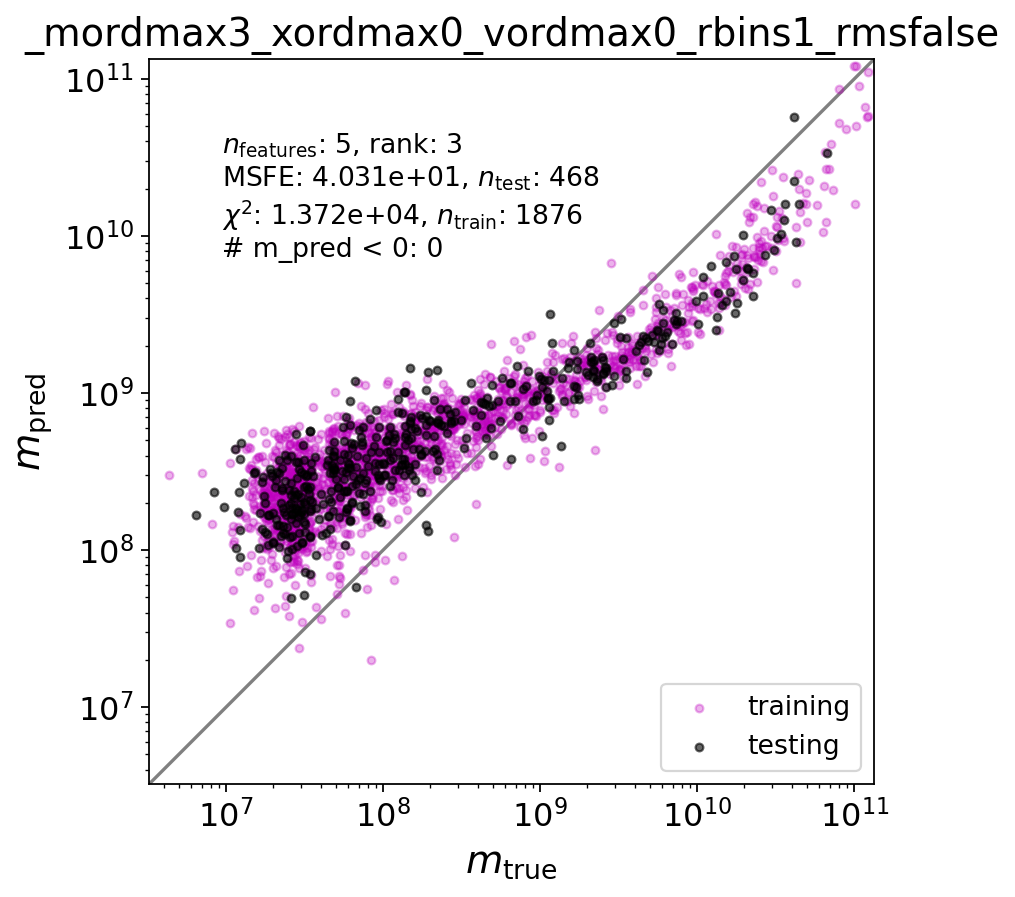

In [19]:
save_tag = f'_mordmax{m_order_max}_xordmax{x_order_max}_vordmax{v_order_max}_rbins{n_rbins}{tag}'
save_fn = f'mass_recovery{save_tag}.png'
plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                  fitter, msfe_test, chi2_train, save_fn=save_fn)

In [20]:
masses_all = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])*mass_multiplier
mass = masses_all[fitter.idx_test]
mass_train = masses_all[fitter.idx_train]

In [21]:
if show_intermediate_plots and n_rbins==1:
    plot_feature_vs_mass(masses_all, featurizer)

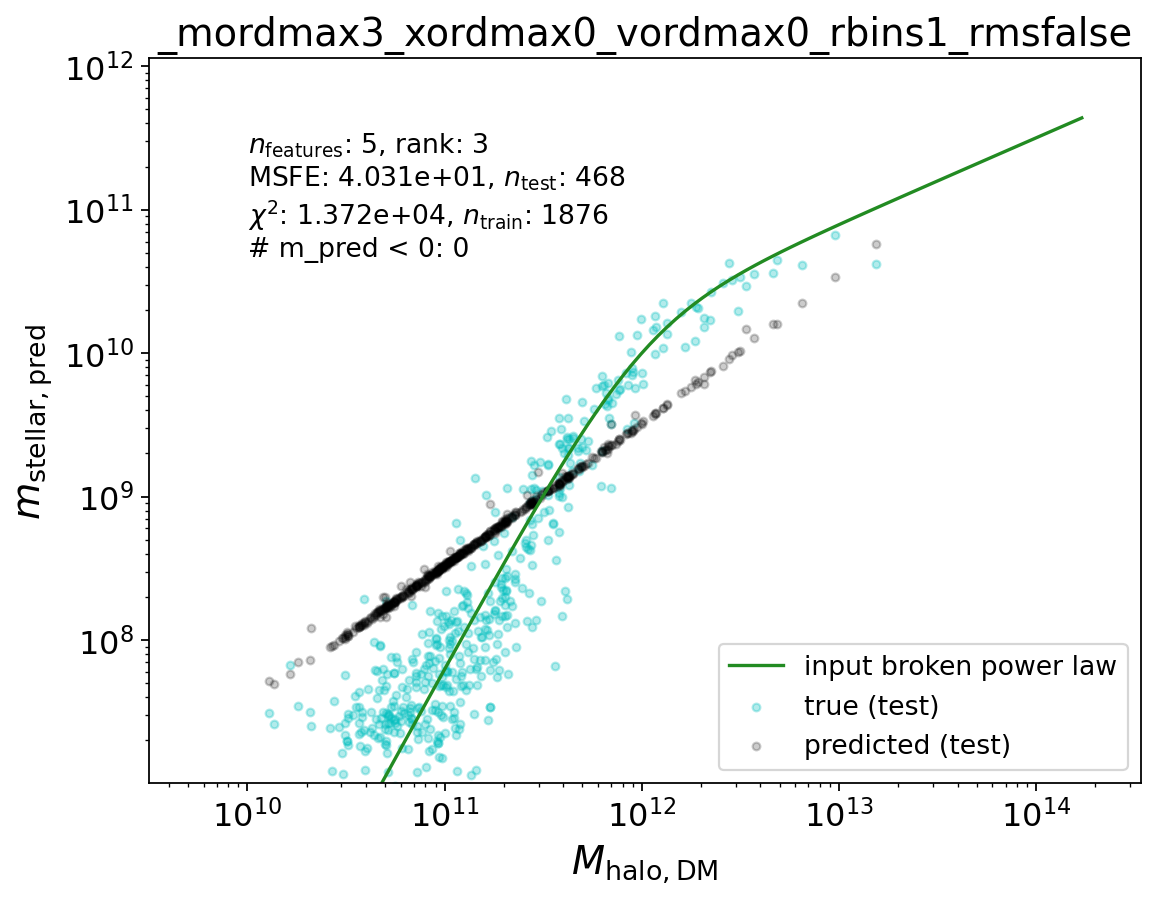

In [22]:
save_fn = f'mass_vs_pred{save_tag}.png'
plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train_true, y_train_pred, 
              fitter, msfe_test, chi2_train, save_fn=save_fn)

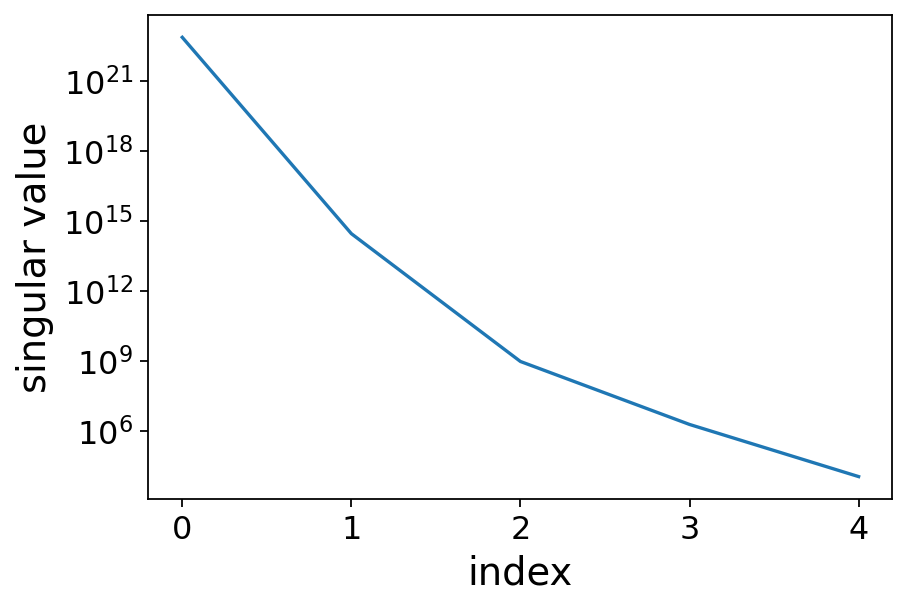

In [23]:
plt.plot(fitter.res_scalar[3])
plt.xlabel('index')
plt.ylabel('singular value')
plt.yscale('log')